# Analyzing & Visualizing Data


* Visualizing users and reviews.

* Analyzing the structures of data and extracting important information.

# Importing

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta

In [2]:
# Plotting import
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
from learntools.time_series.utils import plot_periodogram, seasonal_plot # Kaggle Learning tools
from learntools.time_series.style import *  # plot style settings

import seaborn as sns
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
from pathlib import Path
comp_dir = Path('../input/amazon-product-reviews')

## Importing Data

In [4]:
# This is Electronics dataset
electronics_data=pd.read_csv(comp_dir / "ratings_Electronics (1).csv", dtype={'Rating': 'int8'},
                             names=['userId', 'productId','Rating','timestamp'], index_col=None, header=0)
#electronics_data.drop("timestamp",axis=1, inplace=True)
electronics_data.head()

,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5,1341100800
1,A2NWSAGRHCP8N5,0439886341,1,1367193600
2,A2WNBOD3WNDNKT,0439886341,3,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1,1334707200
4,A1QGNMC6O1VW39,0511189877,5,1397433600


# Analyzing Data

In [5]:
printmd("**Number of Rating**: {:,}".format(electronics_data.shape[0]) )
printmd("**Columns**: {}".format( np.array2string(electronics_data.columns.values)) )
printmd("**Number of Users**: {:,}".format(len(electronics_data.userId.unique()) ) )
printmd("**Number of Products**: {:,}".format(len(electronics_data.productId.unique())  ) )

**Number of Rating**: 7,824,481

**Columns**: ['userId' 'productId' 'Rating' 'timestamp']

**Number of Users**: 4,201,696

**Number of Products**: 476,001

In [6]:
electronics_data.describe()['Rating'].reset_index()

,index,Rating
0,count,7.824481e+06
1,mean,4.012337e+00
2,std,1.380910e+00
3,min,1.000000e+00
4,25%,3.000000e+00
5,50%,5.000000e+00
6,75%,5.000000e+00
7,max,5.000000e+00


**There is no rating below 1** because the minimum rating is 1.

In [7]:
#Check for missing values
printmd('**Number of missing values**:')
pd.DataFrame(electronics_data.isnull().sum().reset_index()).rename( columns={0:"Total missing","index":"Columns"}) 

**Number of missing values**:

,Columns,Total missing
0,userId,0
1,productId,0
2,Rating,0
3,timestamp,0


<h3 style="color:red" >It's good that there is no missing data</h2>

In [8]:
data_by_date = electronics_data.copy()
data_by_date.timestamp = pd.to_datetime(electronics_data.timestamp, unit="s")#.dt.date
data_by_date = data_by_date.sort_values(by="timestamp", ascending=False).reset_index(drop=True)
printmd("**Number of Ratings each day:**")
data_by_date.groupby("timestamp")["Rating"].count().tail(10).reset_index()

**Number of Ratings each day:**

,timestamp,Rating
0,2014-07-14,9701
1,2014-07-15,6892
2,2014-07-16,5943
3,2014-07-17,4781
4,2014-07-18,4912
5,2014-07-19,4183
6,2014-07-20,4273
7,2014-07-21,5458
8,2014-07-22,5010
9,2014-07-23,695


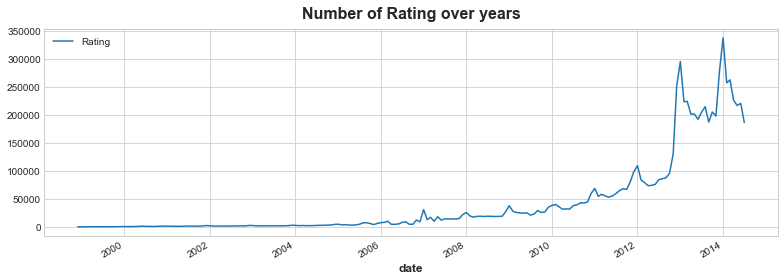

In [9]:
data_by_date["year"]  = data_by_date.timestamp.dt.year
data_by_date["month"] = data_by_date.timestamp.dt.month
rating_by_year = data_by_date.groupby(["year","month"])["Rating"].count().reset_index()
rating_by_year["date"] = pd.to_datetime(rating_by_year["year"].astype("str")  +"-"+rating_by_year["month"].astype("str") +"-1")
rating_by_year.plot(x="date", y="Rating")
plt.title("Number of Rating over years")
plt.show()

## Rating vs User

In [10]:
ratings = electronics_data.groupby("Rating").agg({"Rating":"count"})

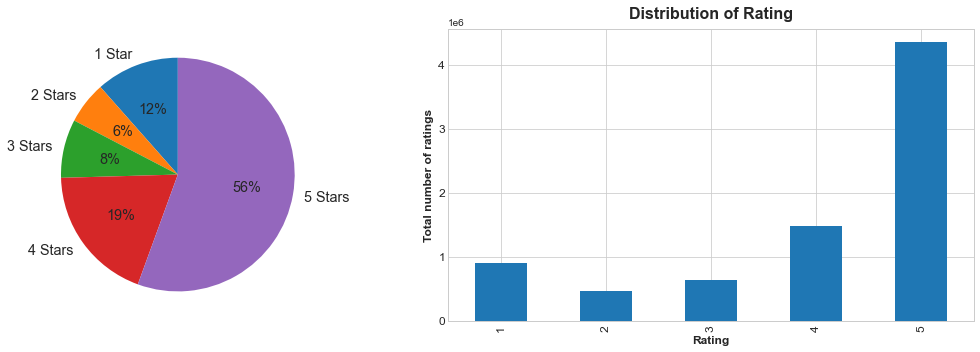

In [11]:
figsize = (15,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)
ratings.plot.pie(ax=ax1,y="Rating", legend=False, autopct='%1.f%%', startangle=90, fontsize="x-large", 
                 labels=["1 Star","2 Stars","3 Stars","4 Stars","5 Stars"])
ax1.set_ylabel('')
ratings.plot.bar(ax=ax2,  fontsize="large")
ax2.set(ylabel="Total number of ratings")
ax2.set(title="Distribution of Rating")
ax2.get_legend().remove()

plt.show()

In [12]:
rating_by_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

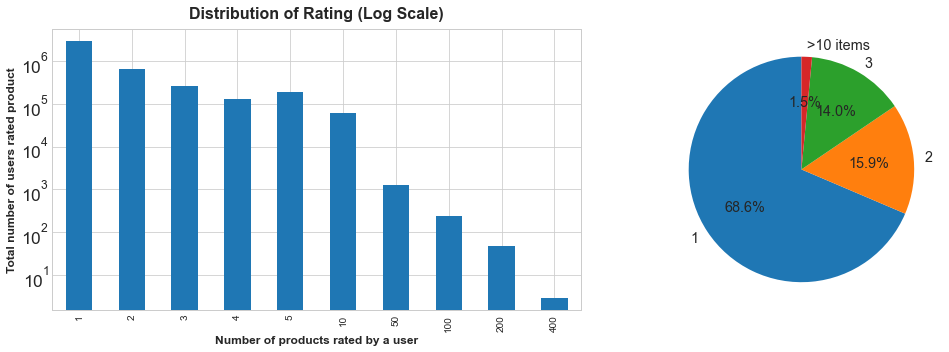

In [13]:
rating_hist,  bins  = np.histogram(rating_by_user, bins=[1,2,3,4,5,10,50,100,200,400,500])
rating_hist2, bins2 = np.histogram(rating_by_user, bins=[1,2,3,10,100000])


figsize = (15,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)

pd.DataFrame({"Numbers of User":rating_hist,"Total Rates":bins[:-1]}).plot.bar(x="Total Rates", ax=ax1)
ax1.set(yscale="log")
ax1.set(ylabel="Total number of users rated product", xlabel="Number of products rated by a user")
ax1.set(title="Distribution of Rating (Log Scale)")
ax1.get_legend().remove()
[item.set_fontsize("xx-large") for item in ax1.get_yticklabels()]

pd.DataFrame({"Numbers of User":rating_hist2,"Total Rates":bins2[:-1]}).plot.pie(x="Total Rates",y="Numbers of User",
              labels=[1,2,3,">10 items"], ax=ax2,legend=False, autopct='%1.1f%%', startangle=90, fontsize="x-large")
ax2.set_ylabel('')

plt.show()

<h3 style="color:red" >Only 1.5% of users rated more than 10 products</h3>

## Rating vs Product

In [14]:
#rating_by_product = electronics_data.groupby(by='productId')['Rating'].count().sort_values(ascending=False).reset_index()
rating_by_product = electronics_data.groupby("productId").agg({"userId":"count","Rating":"mean"}).rename(
                        columns={"userId":"Number of Ratings", "Rating":"Average Rating"}).reset_index()

In [15]:
printmd("**Top 10 products by Number of Rating**")
rating_by_product.sort_values(by="Number of Ratings",ascending=False ).reset_index(drop=True).head(10)

**Top 10 products by Number of Rating**

,productId,Number of Ratings,Average Rating
0,B0074BW614,18244,4.491504
1,B00DR0PDNE,16454,3.931020
2,B007WTAJTO,14172,4.424005
3,B0019EHU8G,12285,4.754497
4,B006GWO5WK,12226,4.314657
5,B003ELYQGG,11617,4.392528
6,B003ES5ZUU,10276,4.704749
7,B007R5YDYA,9907,4.690926
8,B00622AG6S,9823,4.420136
9,B0002L5R78,9487,4.448614


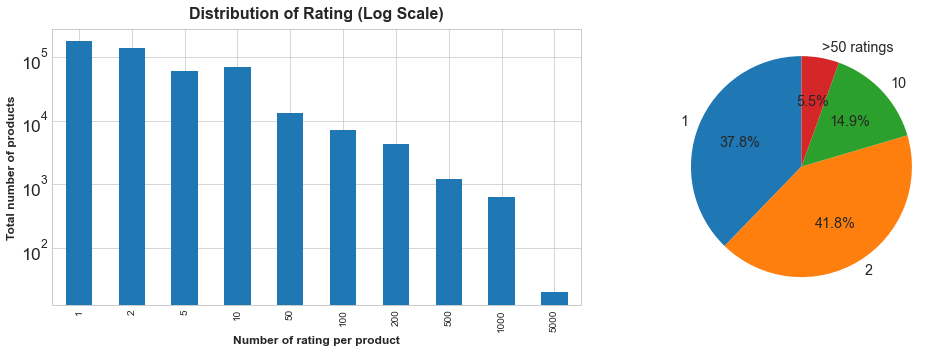

In [16]:
rating_hist,  bins  = np.histogram(rating_by_product["Number of Ratings"], bins=[1,2,5,10,50,100,200,500,1000,5000,10000])
rating_hist2, bins2 = np.histogram(rating_by_product["Number of Ratings"], bins=[1,2,10,50,100000])


figsize = (15,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)

pd.DataFrame({"Numbers of Products":rating_hist,"Total Rates":bins[:-1]}).plot.bar(x="Total Rates", ax=ax1)
ax1.set(yscale="log")
ax1.set(ylabel="Total number of products", xlabel="Number of rating per product")
ax1.set(title="Distribution of Rating (Log Scale)")
ax1.get_legend().remove()
[item.set_fontsize("xx-large") for item in ax1.get_yticklabels()]

pd.DataFrame({"Numbers of User":rating_hist2,"Total Rates":bins2[:-1]}).plot.pie(x="Total Rates",y="Numbers of User",
              labels=[1,2,10,">50 ratings"], ax=ax2,legend=False, autopct='%1.1f%%', startangle=90, fontsize="x-large")
ax2.set_ylabel('')

plt.show()

<h3 style="color:red" >Only 5.5% of products rated by more than 50 people</h3>

## Products by Average Rating

In [17]:
# Define Cutoff is the value where the products is counted when its number of ratings is greater than.
# product with less than cutoff number of ratings will be neglected
cutoff = 50
top_rated = rating_by_product.loc[rating_by_product["Number of Ratings"]>cutoff].sort_values(
                                by="Average Rating",ascending=False).reset_index(drop=True)

In [18]:
printmd("**Top 5 Products have the highest Ratings**")
top_rated.head(5)

**Top 5 Products have the highest Ratings**

,productId,Number of Ratings,Average Rating
0,B002E6R7NG,51,4.980392
1,B004I763AW,60,4.966667
2,B003J9QQWU,56,4.964286
3,B0043ZLFXE,90,4.955556
4,B000TMFYBO,64,4.953125


In [19]:
printmd("**With cutoff = {} we have only {:,} products.**".format(cutoff,top_rated.shape[0] ))
top_rated.describe()

**With cutoff = 50 we have only 25,758 products.**

,Number of Ratings,Average Rating
count,25758.000000,25758.000000
mean,207.737907,3.981259
std,441.408929,0.526451
min,51.000000,1.127273
25%,68.000000,3.679414
50%,102.000000,4.075472
75%,191.000000,4.375000
max,18244.000000,4.980392


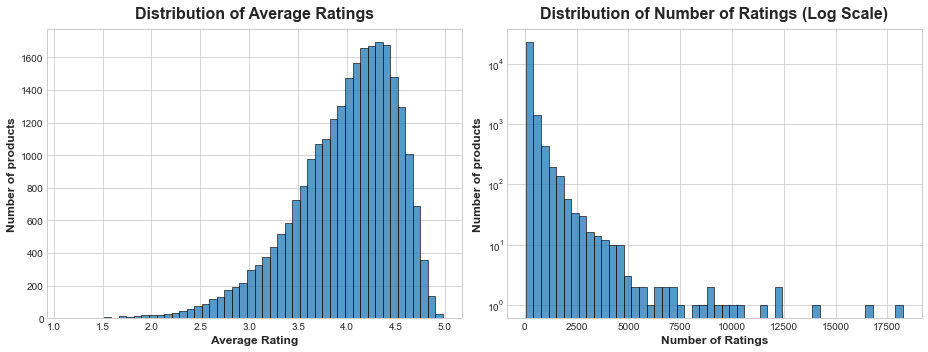

In [20]:
figsize = (13,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)
sns.histplot(data=top_rated["Average Rating"], bins=50, ax=ax1)
ax1.set(title="Distribution of Average Ratings", ylabel="Number of products")

sns.histplot(data=top_rated["Number of Ratings"], bins=50, ax=ax2)
ax2.set(title="Distribution of Number of Ratings (Log Scale)")
ax2.set(yscale="log", ylabel="Number of products")
plt.show();


**Joint Graph**

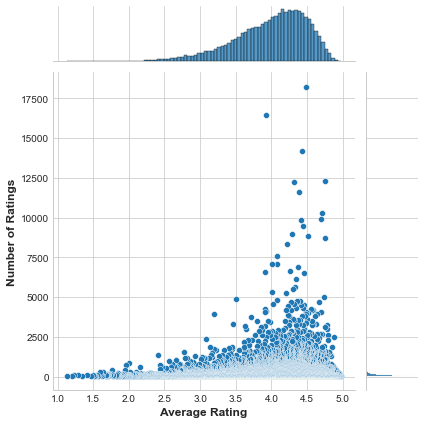

In [21]:
printmd("**Joint Graph**")
sns.jointplot(x='Average Rating', y='Number of Ratings', data=top_rated);

## Recently Polular Items

### Top products rated during period of 30 days

In [22]:
begin_date     = data_by_date.timestamp[0] - timedelta(days=30)
data_by_date30 = data_by_date.loc[ data_by_date.timestamp > begin_date  ]
products_30days= data_by_date30.groupby(["productId"]).agg({"Rating":["mean","count"]}).droplevel(axis=1,level=0).reset_index()

<h3 style="color:red" >List of top products by number of rating </h3>

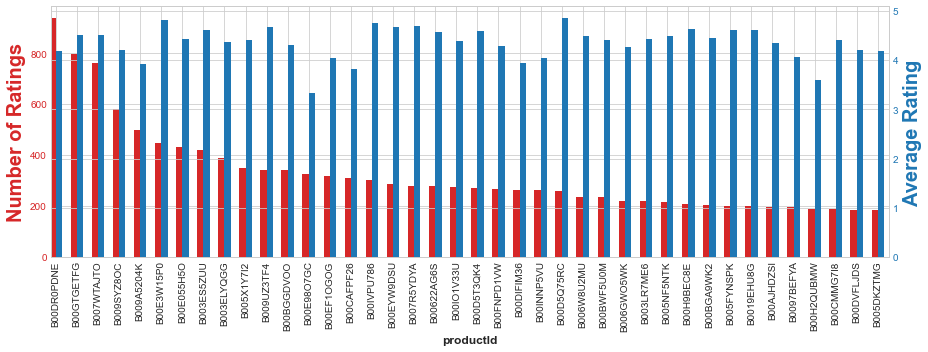

In [23]:
top_rated = products_30days.sort_values(by="count", ascending=False).head(40)

printmd('<h3 style="color:red" >List of top products by number of rating </h3>')
figsize = (13,5)
fig0, ax1 = plt.subplots(figsize=figsize)
ax2 = ax1.twinx()
top_rated.plot(kind = "bar",x="productId", y="count", 
                        ax=ax1,align='edge', color="tab:red", width=-0.3, legend=False)
top_rated.plot(kind = "bar",x="productId", y="mean", 
                        ax=ax2, align='edge',color="tab:blue", width=0.3, legend=False)
############# Style Set up ###############
ax1.set_ylabel('Number of Ratings', color="tab:red", fontsize=20)
ax1.tick_params(axis='y', labelcolor="tab:red")
ax2.set_ylabel('Average Rating', color="tab:blue", fontsize=20)
ax2.tick_params(axis='y', labelcolor="tab:blue")

plt.tight_layout()
plt.show()

<h3 style="color:red" >List of top products by Average Rating </h3>

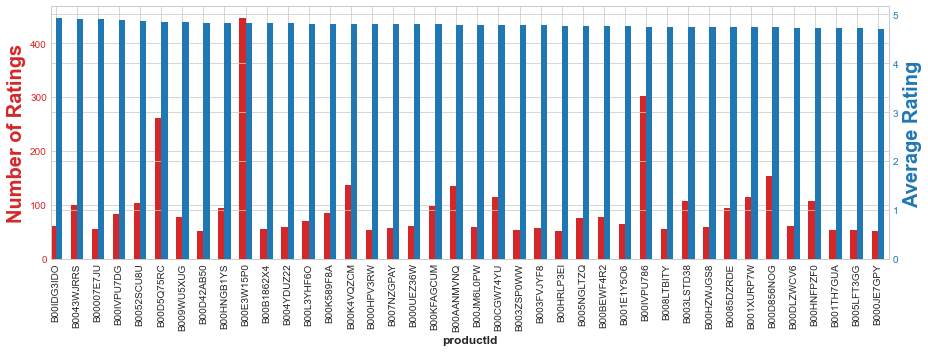

In [24]:
top_rated = products_30days.loc[products_30days["count"] > 50].sort_values(by="mean", ascending=False).head(40)

printmd('<h3 style="color:red" >List of top products by Average Rating </h3>')
figsize = (13,5)
fig0, ax1 = plt.subplots(figsize=figsize)
ax2 = ax1.twinx()
top_rated.plot(kind = "bar",x="productId", y="count", 
                        ax=ax1,align='edge', color="tab:red", width=-0.3, legend=False)
top_rated.plot(kind = "bar",x="productId", y="mean", 
                        ax=ax2, align='edge',color="tab:blue", width=0.3, legend=False)
############# Style Set up ###############
ax1.set_ylabel('Number of Ratings', color="tab:red", fontsize=20)
ax1.tick_params(axis='y', labelcolor="tab:red")
ax2.set_ylabel('Average Rating', color="tab:blue", fontsize=20)  
ax2.tick_params(axis='y', labelcolor="tab:blue")

plt.tight_layout()
plt.show()